# PoseNet for Self-Localization Task on Apolloscape Dataset

PoseNet implementation on Apolloscape dataset. It's a part of the localization methods exploration for Apolloscape Self-Localization Challenge on [ECCV 2018](http://apolloscape.auto/ECCV/challenge.html)

In [3]:
# Load all dependency
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params, quaternion_angular_error

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

`APOLLO_PATH` is a location with unpacked Apolloscape datasets, e.g. `$APOLLO_PATH/road02_seg` or `$APOLLO_PATH/zpark`. Download data from [Apolloscape page](http://apolloscape.auto/scene.html) and unpack it to the `APOLLO_PATH` dir. Let's we've symbolically linked `APOLLO_PATH` folder to `./data/apolloscape`.

In [4]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])

experiment_name = 'zpark_L6'

pretrained = True
stereo = False
shuffle = True

batch_size = 40

train_record = None # 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)

val_record = None # 'Record013'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True, stereo=stereo)


print(train_dataset)
print(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: True
    Normalize Poses: True
    Stereo: False
    Length: 2242 of 2242
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: False
    Normalize Poses: True
    Stereo: False
    Length: 756 of 756
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



## Draw Train and Val datasets

Visualize poses from `train` and `val` datasets to check that it covers all val path.

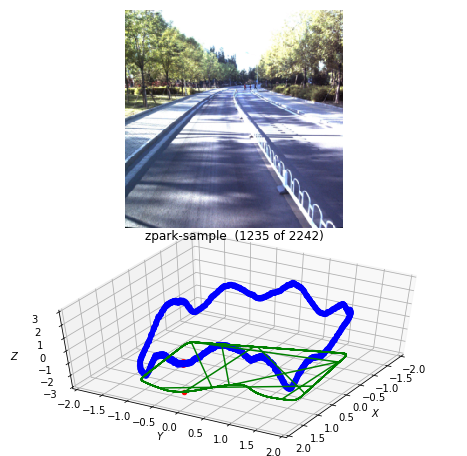

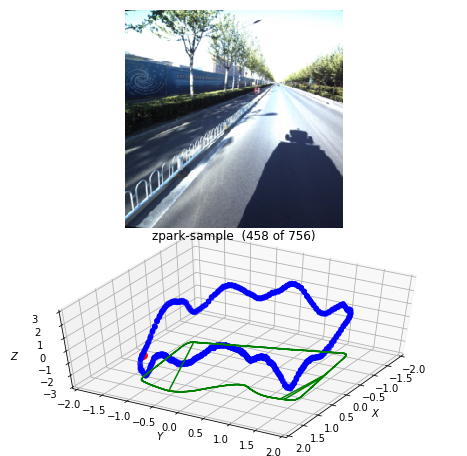

In [5]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()


## Device set up

Determine the primary device and use it for training/validation.

In [6]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

Train function runs one epoch through training data.

In [11]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True,
          poses_mean=None, poses_std=None, stereo = True):
    
    # switch model to training
    model.train()
    
    losses = AverageMeter()
    
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
                else batch_images.size(0))
        
        
        # move data to cpu & numpy
        if stereo:
            bp = [x.detach().cpu().numpy() for x in batch_poses]
            outp = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *bp))
            pred_poses = np.vstack((pred_poses, *outp))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))
        
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
#             print('{} {losses.val:.3f} {losses.avg:.3f}'.format(batch_time, losses=losses))
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))

            
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     if unnorm:
#         print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
#     print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
#     print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

            
    if print_sum:
        print('Ep: [{}/{}]\tTrain Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s\t{criterion_sx:.5f}:{criterion_sq:.5f}'.format(
            epoch, max_epoch - 1, losses.avg, np.mean(t_loss), np.mean(q_loss),
            (time.time() - epoch_time), criterion_sx=criterion.sx.data[0], criterion_sq=criterion.sq.data[0]))
        
#     return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True, stereo=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            
            if stereo:
                batch_images = [x.to(device) for x in batch_images]
                batch_poses = [x.to(device) for x in batch_poses]
            else:
                batch_images = batch_images.to(device)
                batch_poses = batch_poses.to(device)
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(batch_images) * batch_images[0].size(0) if stereo
                    else batch_images.size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
                                                                               (time.time() - epoch_time)))
        
#     return losses.avg


## Create Model, Criterion and Optimizer

PoseNet implementation is a ResNet based feature extractor that ends with custom fully-connected regressor layers for translation (3D pose) and rotation (quaternion).

In [8]:
# Create pretrained feature extractor
# feature_extractor = models.resnet18(pretrained=True)
feature_extractor = models.resnet34(pretrained=pretrained)
# feature_extractor = models.resnet50(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = PoseNet(feature_extractor, num_features=num_features, pretrained=pretrained)
model = model.to(device)

# Criterion
# criterion = PoseNetCriterion(stereo=stereo, beta=500.0)
criterion = PoseNetCriterion(stereo=stereo, learn_beta=True)
criterion = criterion.to(device)

param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    print('crit_params = {}'.format(criterion.parameters()))
    param_list.append({'params': criterion.parameters()})

# Create optimizer
optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)

start_epoch = 0


crit_params = <generator object Module.parameters at 0x7f8a469d5ba0>


## Restore from Chekpoint

It helps to continue training later or just use it for the inference.

In [9]:
# Restore from checkpoint
# checkpoint_file = '_checkpoints/20180812_143625_nb_zpark_L4_e600.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


## Run Training

Training loop that runs for `n_epochs` with validation every `val_freq` epochs.

In [12]:
if 'start_epoch' not in locals():
    start_epoch = 0
    
n_epochs = start_epoch + 150

print('Training ...')
val_freq = 5
for e in range(start_epoch, n_epochs):
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0,
         poses_mean=train_dataset.poses_mean, poses_std=train_dataset.poses_std, stereo=stereo)
    if e % val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=0, stereo=stereo)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Ep: [0/149]	Train Loss: 0.616	Te: 93.653	Re: 66.819	 Et: 21.37s	0.00142:-0.00207
Epoch: [0]	Validation Loss: 0.855	Epoch time: 5.178
Ep: [1/149]	Train Loss: 0.540	Te: 86.482	Re: 58.565	 Et: 21.20s	0.00175:-0.00276
Ep: [2/149]	Train Loss: 0.474	Te: 78.282	Re: 51.155	 Et: 21.24s	0.00206:-0.00345
Ep: [3/149]	Train Loss: 0.434	Te: 71.764	Re: 46.046	 Et: 21.26s	0.00236:-0.00412
Ep: [4/149]	Train Loss: 0.414	Te: 70.241	Re: 41.559	 Et: 21.26s	0.00267:-0.00479
Ep: [5/149]	Train Loss: 0.377	Te: 64.404	Re: 36.957	 Et: 21.31s	0.00299:-0.00545
Epoch: [5]	Validation Loss: 0.703	Epoch time: 5.249
Ep: [6/149]	Train Loss: 0.375	Te: 59.123	Re: 37.775	 Et: 21.19s	0.00332:-0.00609
Ep: [7/149]	Train Loss: 0.334	Te: 60.226	Re: 33.426	 Et: 21.26s	0.00364:-0.00674
Ep: [8/149]	Train Loss: 0.327	Te: 54.618	Re: 33.106	 Et: 21.24s	0.00395:-0.00737
Ep: [9/149]	Train Loss: 0.342	Te: 59.645	Re: 32.235	 Et: 21.24s	0.00430:-0.00800
Ep: [10/149]	Train Loss: 0.314	Te: 56.626	Re: 29.608	 Et: 21.28s	0.00464:

Ep: [89/149]	Train Loss: 0.076	Te: 26.077	Re: 9.467	 Et: 20.90s	0.03567:-0.05501
Ep: [90/149]	Train Loss: 0.069	Te: 23.662	Re: 9.458	 Et: 20.88s	0.03609:-0.05559
Epoch: [90]	Validation Loss: 0.183	Epoch time: 5.154
Ep: [91/149]	Train Loss: 0.067	Te: 23.776	Re: 9.505	 Et: 20.95s	0.03651:-0.05616
Ep: [92/149]	Train Loss: 0.063	Te: 21.227	Re: 9.481	 Et: 20.92s	0.03691:-0.05674
Ep: [93/149]	Train Loss: 0.068	Te: 22.366	Re: 9.727	 Et: 20.92s	0.03732:-0.05731
Ep: [94/149]	Train Loss: 0.065	Te: 22.673	Re: 9.709	 Et: 21.00s	0.03775:-0.05789
Ep: [95/149]	Train Loss: 0.058	Te: 24.107	Re: 8.642	 Et: 21.02s	0.03817:-0.05846
Epoch: [95]	Validation Loss: 0.188	Epoch time: 5.183
Ep: [96/149]	Train Loss: 0.061	Te: 21.239	Re: 9.767	 Et: 21.06s	0.03861:-0.05904
Ep: [97/149]	Train Loss: 0.058	Te: 20.634	Re: 9.550	 Et: 21.09s	0.03902:-0.05961
Ep: [98/149]	Train Loss: 0.053	Te: 19.823	Re: 8.873	 Et: 21.09s	0.03944:-0.06019
Ep: [99/149]	Train Loss: 0.050	Te: 21.228	Re: 8.744	 Et: 21.02s	0.03985:-0.06076
Ep:

## Test Model Error on Validation and Train Datasets

Calculate translation and rotation error of the predicted poses on train and validation datasets.

In [ ]:
def model_results_pred_gt(model, dataloader, poses_mean, poses_std, stereo=True):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        
        if stereo:
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)


        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        # move data to cpu & numpy
        if stereo:
            batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
            out = [x.detach().cpu().numpy() for x in out]
            gt_poses = np.vstack((gt_poses, *batch_poses))
            pred_poses = np.vstack((pred_poses, *out))
        else:
            bp = batch_poses.detach().cpu().numpy()
            outp = out.detach().cpu().numpy()
            gt_poses = np.vstack((gt_poses, bp))
            pred_poses = np.vstack((pred_poses, outp))


        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses


# Get mean and std from dataset
poses_mean = val_dataset.poses_mean
poses_std = val_dataset.poses_std



print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_dataloader, poses_mean, poses_std, stereo=stereo)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses


print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, val_dataloader, poses_mean, poses_std, stereo=stereo)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses



### Visualize Prediction and Ground Truth Poses

Draw ground truth in `blue` and predictions in `red` colors.

In [ ]:
def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()

    
# print(pred_poses_train)
# print(gt_poses_train)

# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('PoseNet on Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('PoseNet on Validation Dataset')
plt.show()



## Save Model Checkpoint

In [ ]:
# Save checkpoint
# n_epochs = 4203
save_checkpoint(model, optimizer, 'nb_{}'.format(experiment_name), n_epochs)
    